In [1]:
import pandas as pd
from siuba import *
from siuba.siu import call
from plotnine import *
import json
import matplotlib.pyplot as pp
import tidytext
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import string
import random
import nltk
from nltk import FreqDist
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

np.random.seed(500)

In [2]:
import pins

board = pins.board_folder(".")

numeric_df = board.pin_read("train_data")

In [3]:
numeric_df.drop(columns=["allow_forking"], inplace=True)
nonone = (numeric_df 
    >> select(_.description)
    >> filter(-_.description.isin([None])))

In [4]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(frozenset({'b', 's'}))

In [5]:
tokenizer = RegexpTokenizer(r'\w+')
sents  = nonone.description.to_list()

for sent in sents:
    remove_emojis(sent)

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(sents) 

In [6]:
def get_topics(lda_model, tfidf_model, data):
    terms = tfidf_model.get_feature_names_out()
    # Fit and Transform SVD model on data
    lda_matrix = lda_model.fit_transform(data)
    lda_components = lda_model.components_

    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)
    
    return lda_matrix, lda_components

In [7]:
# visualize topics
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 28})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [8]:
# https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
# good PCA refresher https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e


def pca_plot(transformed_data, components):

    x = transformed_data[:, 0]
    y = transformed_data[:, 1]
    n = components.shape[0]

    plt.scatter(x, y)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    for i in range(n):
        plt.arrow(0, 0, components[i, 0], components[i, 1], color="black", alpha=0.5)
        plt.text(
            components[i, 0] * 1.3,
            components[i, 1] * 1.3,
            "Var " + str(i + 1),
            color="black",
            ha="center",
            va="center",
        )

def most_important_feature(components, data):
    most_important = [np.abs(components[i]).argmax() for i in range(components.shape[0])]

    initial_feature_names = data.columns

    most_important_names = [initial_feature_names[most_important[i]] for i in range(components.shape[0])]

    dic = {'PC{}'.format(i): most_important_names[i] for i in range(components.shape[0])}


    return pd.DataFrame(dic.items())

# LDA

In [9]:
# model_05=LatentDirichletAllocation(n_components=5)
# get_topics(model_05, tfidf, train_data)

In [10]:
# model_10=LatentDirichletAllocation(n_components=10)
# get_topics(model_10, tfidf, train_data)

In [11]:
# model_12=LatentDirichletAllocation(n_components=12)
# get_topics(model_12, tfidf, train_data)

In [12]:
model_20=LatentDirichletAllocation(n_components=20)
matrix, components = get_topics(model_20, tfidf, train_data)

Topic 0:  ['end', 'ci', 'sagemaker', 'cd', 'pipeline', 'mlops', 'store']
Topic 1:  ['learning', 'mlops', 'machine', 'azure', 'python', 'projects', 'library']
Topic 2:  ['ml', 'code', 'learning', 'project', 'using', 'machine', 'repository']
Topic 3:  ['docker', 'tutorial', 'image', 'mlflow', 'mlops', 'airflow', 'internship']
Topic 4:  ['example', 'pytorch', 'version', 'deep', 'kubernetes', 'deploy', 'learning']
Topic 5:  ['model', 'dvc', '66daysofdata', 'app', 'data', 'triton', 'ml']
Topic 6:  ['deeplearning', 'specialization', 'ai', 'ml', 'learning', 'mlops', 'machine']
Topic 7:  ['end', 'learning', 'machine', 'platform', 'data', 'mlops', 'kubeflow']
Topic 8:  ['deployment', 'model', 'ai', 'cloud', 'google', 'integration', 'ml']
Topic 9:  ['tensorflow', 'mlops', 'project', 'extended', 'pipelines', 'ml', 'tool']
Topic 10:  ['action', 'zoomcamp', 'github', 'mlops', 'repo', 'machine', 'learning']
Topic 11:  ['model', 'list', 'curated', 'experiment', 'awesome', 'tracking', 'registry']
Topi

In [13]:
# add topic to dataframe
topic = []
for n in range(matrix.shape[0]):
    topic.append(matrix[n].argmax())
numeric_df["lda_topic"] = topic

/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B}) missing from current font.
/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30330 (\N{CJK UNIFIED IDEOGRAPH-767A}) missing from current font.
/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from current font.
/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/sit

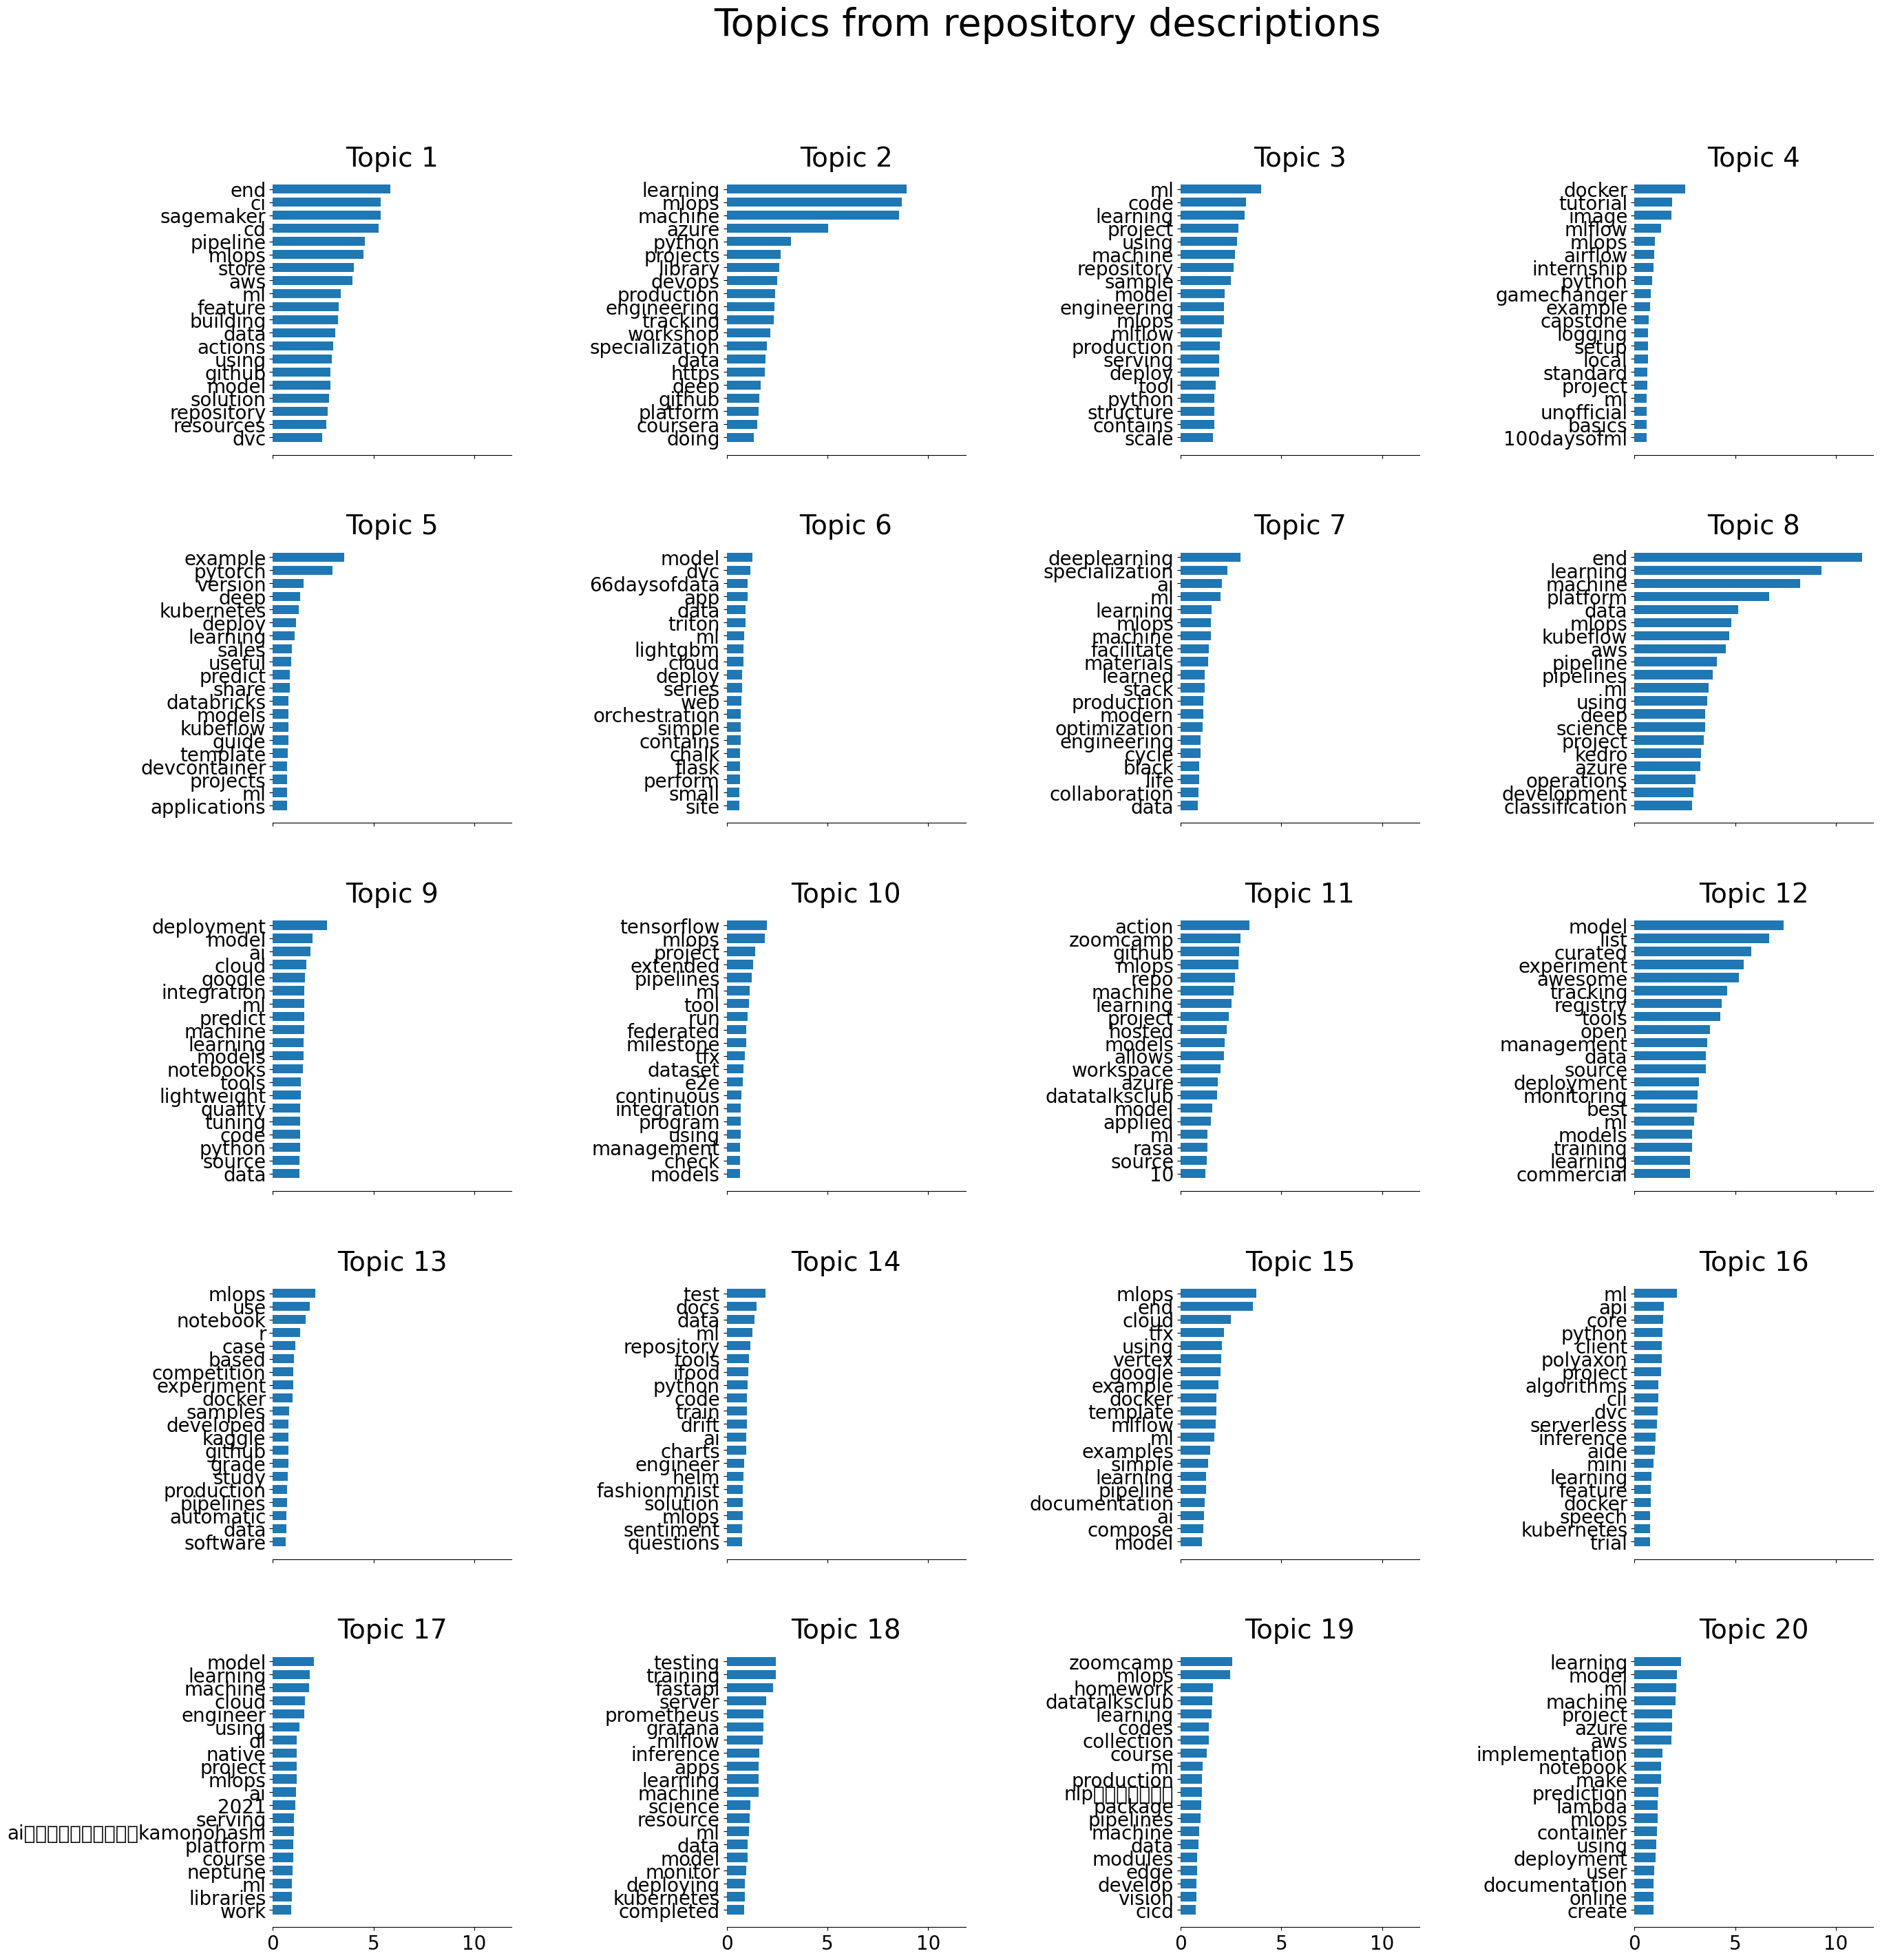

In [14]:
## rerun with grid of different numbers of topics + document
plot_top_words(model_20, tfidf.get_feature_names_out(), 20, "Topics from repository descriptions")

In [15]:
numeric_df.drop(columns=['description'], inplace=True)

# Scaled PCA

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder().fit_transform(numeric_df['lda_topic'])
scaled_numeric_df = StandardScaler().fit_transform(numeric_df)
pca_numeric_scaled = PCA(n_components=2).fit(scaled_numeric_df)
pca_numeric_scaled_output = pca_numeric_scaled.transform(scaled_numeric_df)

In [27]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(
    [("le", preprocessing.LabelEncoder()), 
    ("scaler", StandardScaler()), 
    ("pca", PCA()),
    ("dbscan", DBSCAN())]
)


In [29]:
pipe.fit(numeric_df)

TypeError: fit_transform() takes 2 positional arguments but 3 were given

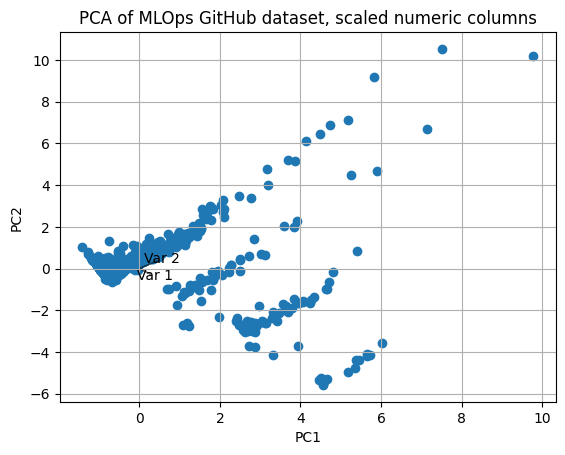

In [17]:
plt.title("PCA of MLOps GitHub dataset, scaled numeric columns")

pca_plot(pca_numeric_scaled_output, pca_numeric_scaled.components_) 
plt.show()

# DBSCAN

In [18]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps = 0.5, min_samples=5).fit(pca_numeric_scaled_output)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 33


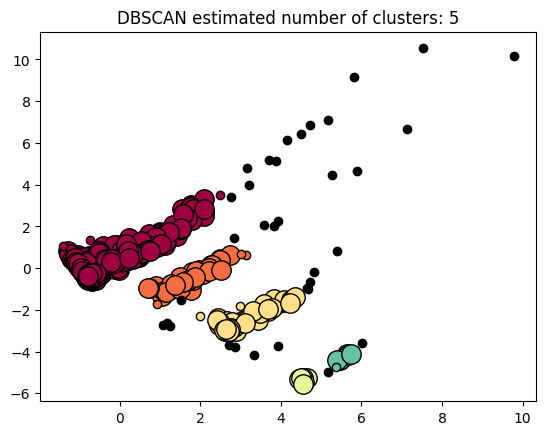

In [19]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = pca_numeric_scaled_output[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = pca_numeric_scaled_output[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"DBSCAN estimated number of clusters: {n_clusters_}")
plt.show()

In [20]:
numeric_df['clustering_labels'] = db.fit_predict(pca_numeric_scaled_output)

In [21]:
from sklearn import metrics
metrics.silhouette_score(pca_numeric_scaled_output, numeric_df['clustering_labels'])

0.6235151746664813

doesn’t have overlapping clusters or mislabeled data points.

In [22]:
numeric_df.columns

Index(['stargazers_count', 'has_issues', 'has_projects', 'has_downloads',
       'has_wiki', 'has_pages', 'has_discussions', 'open_issues_count',
       'is_template', 'age_days', 'time_since_last_commit_days', 'lda_topic',
       'clustering_labels'],
      dtype='object')

In [23]:
(numeric_df
    >> group_by(_.clustering_labels)
    >> summarize(
        avg_stars = _.stargazers_count.mean(),
        avg_has_issues = _.has_issues.mean(),
        avg_has_projects = _.has_projects.mean(),
        avg_has_downloads = _.has_downloads.mean(),
        avg_has_wiki = _.has_wiki.mean(),
        avg_has_pages = _.has_pages.mean(),
        avg_has_discussions = _.has_discussions.mean(),
        avg_open_issues_count = _.open_issues_count.mean(),
        avg_is_template = _.is_template.mean(),
        avg_age_days = _.age_days.mean(),
        avg_last_commit = _.time_since_last_commit_days.mean(),
        most_lda_topic = _.lda_topic.mode()[0] + 1
    )
)

,clustering_labels,avg_stars,avg_has_issues,avg_has_projects,avg_has_downloads,avg_has_wiki,avg_has_pages,avg_has_discussions,avg_open_issues_count,avg_is_template,avg_age_days,avg_last_commit,most_lda_topic
0,-1,5077.636364,0.727273,0.727273,1.000000,0.515152,0.303030,0.454545,268.060606,0.030303,1156.363636,38.848485,8
1,0,128.913835,1.000000,1.000000,1.000000,1.000000,0.109223,0.095874,6.394417,0.031553,535.952670,255.978155,8
2,1,251.333333,1.000000,0.939394,1.000000,0.060606,0.333333,0.363636,23.757576,0.060606,531.090909,99.515152,2
3,2,82.085106,1.000000,0.021277,0.978723,0.000000,0.170213,0.212766,7.425532,0.021277,593.021277,117.148936,8
4,3,52.166667,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,239.333333,147.666667,1
5,4,47.833333,0.000000,0.000000,1.000000,0.000000,0.166667,0.000000,8.666667,0.000000,1483.833333,8.333333,9


In [24]:
(numeric_df
    >> count(_.lda_topic)
    >> arrange(-_.n))

,lda_topic,n
7,7,106
11,11,84
0,0,72
1,1,71
2,2,61
8,8,52
10,10,49
14,14,49
19,19,49
15,15,42
